In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
from scipy import ndimage
import cv2 as cv
import easyocr
reader = easyocr.Reader(['en']) 
import itertools

conversion_factor = 0.29072


def remove_outlier(data, diff_threshold=5):


    found = False
   
    for r in range(len(data), 1, -1):  # r represents the combination length
        if found:
            break
        comb = itertools.combinations(range(len(data)), r)
        for c in comb:
            arr = data[np.array(c)] 
            diff = np.max(np.abs(arr[:, np.newaxis] - arr[np.newaxis, :]))
            if diff <= diff_threshold:
                found = True
                break
    return np.array(c)

def rotate_point(image, point, angle_degrees, y_len_new, x_len_new, y_len_beofre, x_len_before):
    
   
    angle_radians = np.deg2rad(angle_degrees)

    # Get image dimensions and center
    height_new, width_new = (y_len_new, x_len_new)
    center_x_new, center_y_new = width_new / 2, height_new / 2
    
    height, width = (y_len_beofre, x_len_before)
    center_x, center_y = width / 2, height / 2

    # Translate the point to be relative to the center
    x_rel, y_rel = point[0] - center_x, point[1] - center_y

    # Apply the rotation matrix
    x_new_rel = x_rel * np.cos(angle_radians) - y_rel * np.sin(angle_radians)
    y_new_rel = x_rel * np.sin(angle_radians) + y_rel * np.cos(angle_radians)

    # Translate the point back
    x_new = x_new_rel + center_x_new
    y_new = y_new_rel + center_y_new

    return np.array([x_new, y_new])

def recognize_square(filename,  x_step=250.0, y_step=500.0, size_min=60, size_max=85):

    results = []
    results_detail = []
    img = cv.imread(filename)[:,:,1]
    img_blur = cv.GaussianBlur(img, (5,5),0)
    edges = cv.Canny(img_blur, 50, 150)
    
   
    # ocr_threshold = 140

    contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    img_canvas = 255*np.ones(img.shape).astype(np.uint8).copy()
    index = 0
    for contour in contours:
        epsilon = 0.05 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)
        
        # If the polygon has 4 vertices, it could be a square
        if len(approx) == 4:
            # Check if it's roughly a square
            # x, y, w, h = cv.boundingRect(approx)
            (x, y), (w, h), angle = cv.minAreaRect(approx)
            
            
            aspect_ratio = float(w) / h
            if 0.8 <= aspect_ratio <= 1.2:  # Square-like aspect ratio
                # Further checks on size and location of square
                
                if size_min <= w <= size_max and size_min <= h <= size_max and -15 <= angle <= angle:
                    # Draw the square or mark it as detected
                    # print(angle)
                    x = int(x)
                    y = int(y)
                    results.append([x, y])
                    results_detail.append([x, y, w, h, angle])

                    cv.drawContours(img_canvas , [approx], 0, (0, 255, 0), 3)

    results = np.array(results)
    results_detail = np.array(results_detail)
    plt.imshow(img_canvas)

    ocr_results = []
    ocr_results_detail = []
    for index, result in enumerate(results):
        y, x = result
        y_view = 100
        x_view_start = -250
        x_view_end = -100
        img_ocr = img[
            max(0,x+x_view_start):min(img.shape[0],x+x_view_end), 
            max(0,y-y_view):min(img.shape[1],y+y_view)]

        
        # img_ocr = np.where(img_ocr > ocr_threshold, 255, 0).astype(np.uint8).copy()
        _, ID, prob = reader.readtext(img_ocr, allowlist='0123456789')[0]
        if len(ID) == 4 and prob >= 0.000:
            ocr_results.append([ID, prob])
            x_rec, y_rec, w_rec, h_rec, angle_rec = results_detail[index]
            location_params = [int(ID), int(x_rec), int(y_rec), angle_rec, prob]
            ocr_results_detail.append(location_params)

    ocr_results_detail = np.array(ocr_results_detail)

    return img, results_detail, ocr_results_detail

def transform(img, 
              ocr_results_detail, 
              square_results_detail, 
              x_step=250.0, 
              y_step=500.0, 
              x_offset=-5625,
              y_offset=-22515):

    IDs = np.array([int(val[0]) for val in ocr_results_detail])
    x_IDs = IDs // 100
    y_IDs = IDs % 100
    # index_list = [i for i in range(len(y_IDs))]
    final_IDs = np.intersect1d(remove_outlier(x_IDs), remove_outlier(y_IDs))
    # final_coords = ocr_results_detail[:,1:3] * conversion_factor 


    coords = ((square_results_detail - square_results_detail[0])* conversion_factor)[1:,:2]
    ref_coords = np.round(np.divide(coords, [x_step, y_step])) @ np.diag([x_step, y_step]) + 1E-8

    rot_angles = (np.arctan2(coords[:,1], coords[:,0]) - np.arctan2(ref_coords[:,1],ref_coords[:,0]) )/ np.pi * 180.0
    corrected_rot_angles = rot_angles - np.round(np.divide(rot_angles, 360.0)) * 360.0
    rot_angle_mean = np.mean(corrected_rot_angles)

    y_len_before, x_len_before = img.shape
    y_len_new, x_len_new = ndimage.rotate(img, -rot_angle_mean).shape
    offset = np.array([x_offset, y_offset])
    translations = []
    for ID in (final_IDs):
        
        point = ocr_results_detail[:,1:3][ID]
        new_loc = rotate_point(img, point,  -rot_angle_mean,
                            y_len_new=y_len_new, x_len_new=x_len_new,
                            y_len_beofre=y_len_before, x_len_before=x_len_before) 
        new_loc_micron = np.array([new_loc[0] - x_len_new/2, y_len_new/2 - new_loc[1]]) * conversion_factor
        print(f'X_id, y_id = {x_IDs[ID]}, {y_IDs[ID]}', end= ' ')
        print(new_loc_micron, end=' \n')

        layout_coords = np.array([x_step * x_IDs[ID], y_step * y_IDs[ID]]) + offset

        # print(final_coords[ID])
        translations.append([layout_coords[0] - new_loc_micron[0], layout_coords[1] - new_loc_micron[1]])
        # print('Coord diff x: ' + str(layout_coords[0] - new_loc_micron[0]))
        # print('Coord diff y: ' + str(layout_coords[1] - new_loc_micron[1]))
    translations = np.array(translations)
    # print(np.mean(translations, axis=0))
    x_transition, y_transition = np.mean(translations, axis=0)
    return (x_transition, y_transition, rot_angle_mean), translations


In [2]:
filename = 'clean.jpg'

X_id, y_id = 20, 80 [ 376.50900139 -581.59108225] 
X_id, y_id = 19, 80 [ 125.24669616 -580.81774161] 
X_id, y_id = 18, 80 [-124.84000893 -580.59967271] 
X_id, y_id = 20, 81 [374.29028039 -79.73233989] 
X_id, y_id = 19, 81 [124.48771683 -79.21711811] 
X_id, y_id = 20, 82 [375.01055974 420.73822316] 


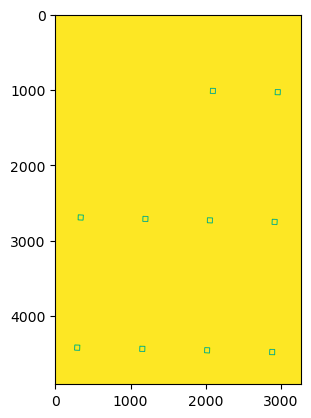

In [3]:
img, square_results_detail, ocr_results_detail = recognize_square(filename=filename)
(x_transition, y_transition, rot_angle_mean), _ = transform(img=img, 
              ocr_results_detail=ocr_results_detail, 
              square_results_detail=square_results_detail)

In [4]:
x_transition, y_transition, rot_angle_mean

(-1000.1173742640852, 18065.20328856842, 1.282259481614321)